Integrantes:
- Ana Luisa Parra Valencia
- Jorge Ivan Pinzón 
- Miguel Angel Nava Perez

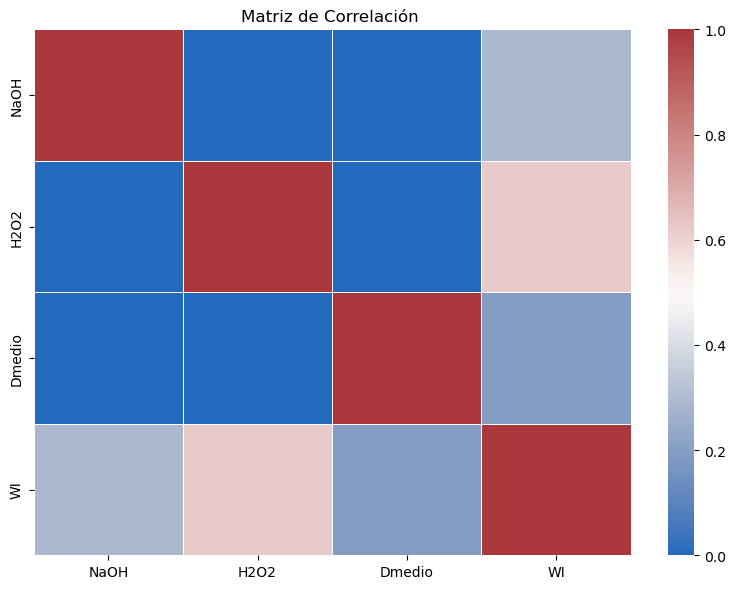

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from tabulate import tabulate #para mostrar el dataframe como una tabla 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, validation_curve, train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
#cargar datos y analizar correlaciones 

df_completo = pd.read_excel('Blanqueamiento.xlsx')

corr_matrix = df_completo.corr()

# Graficar la matriz de correlación con un heatmap
plt.figure(figsize=(8, 6))
plt.title("Matriz de Correlación ")

#no importa si la correlación es positiva o negativa, entonces se puede graficar abs
sns.heatmap(abs(corr_matrix.values), cmap='vlag', fmt=".2f", linewidths=0.5,xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.tight_layout()

In [32]:
# Dividamos los datos en 80% para entrenamiento y 20% para prueba 

df = df_completo.sample(frac=0.8,random_state=42) #datos entrenamiento
df_prueba = df_completo.drop(df.index) #datos para prueba 

#

x =df[["H2O2","NaOH","Dmedio"]]#tres regresores 
x_p =df_prueba[["H2O2","NaOH","Dmedio"]]

y = df["WI"] #variable que se quiere describir o explicar 
y_p = df_prueba["WI"]

modelo = LinearRegression().fit(x,y) # se genera y ajusta el modelo

#usamos los datos de prueba 

y_pred = modelo.predict(x_p) # se calculan los valores predichos. 

# Calcular métricas con los valores predichos 

mse = mean_squared_error(y_p, y_pred)
rmse = np.sqrt(mse) # RMSE
p=df.shape[1] #numero de predictores
RSE = np.sqrt(np.sum((y_p-y_pred)**2)/(len(y_p)-p-1))
r2 = r2_score(y_p, y_pred)
mae = mean_absolute_error(y_p, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')
print(f'RSE: {RSE:.2f}')
print(f'MAE: {mae:.2f}')


x =df_completo[["H2O2","NaOH","Dmedio"]]#tres regresores 

y = df_completo['WI']

# Crear el modelo de regresión lineal
model = LinearRegression().fit(x,y) # se genera y ajusta el modelo
 
# Establecer el número de "folds" (particiones) para la validación cruzada
k = 2

# Crear el objeto KFold (k-particiones) para dividir los datos

kf = KFold(n_splits=k, shuffle=True, random_state=42) #cross-validation splitter

# Realizar k-fold cross-validation
scores1 = cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error')  # Usamos RMSE como métrica
scores = cross_val_score(model, x, y, cv=kf, scoring='r2')  # Usamos R2 como métrica
# Calcular el Error Cuadrático Medio promedio
rmse_promedio = -np.mean(scores1)  # Scikit-learn devuelve los valores negativos para RMSE, así que lo invertimos
R2_promedio = np.mean(scores) #promedio de R2 
print(f'Root Mean Squared Error promedio (RMSE): {rmse_promedio}')
print(f'Coef. de Determinación promedio (R^2): {R2_promedio}')

# residuors

residuos = y_p - modelo.predict(x_p) #residuos 



RMSE: 2.50
R²: 0.43
RSE: 3.53
MAE: 2.24
Root Mean Squared Error promedio (RMSE): 4.0465602763074315
Coef. de Determinación promedio (R^2): 0.1587862639800815


In [33]:
# Definir características (X) y variable objetivo (y)
X_global = df_completo[["H2O2", "NaOH", "Dmedio"]]
y_global = df_completo["WI"]

# --- Evaluación con división Entrenamiento/Prueba ---
print("--- Evaluación con División Entrenamiento/Prueba (CON Interacciones de Grado 3) ---")
X_train, X_test, y_train, y_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)

# Crear el pipeline: Escalar -> Crear Interacciones -> Regresión Lineal

pipeline_con_interacciones = Pipeline([
    ('scaler', StandardScaler()), #escalar antes de interacciones/polinomiales
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('linear_regression', LinearRegression())
])

# Entrenar el pipeline
pipeline_con_interacciones.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_inter_test = pipeline_con_interacciones.predict(X_test)

# Calcular métricas
mse_inter_test = mean_squared_error(y_test, y_pred_inter_test)
rmse_inter_test = np.sqrt(mse_inter_test)
r2_inter_test = r2_score(y_test, y_pred_inter_test)
mae_inter_test = mean_absolute_error(y_test, y_pred_inter_test)

# Para RSE (Residual Standard Error)

p_inter = pipeline_con_interacciones.named_steps['linear_regression'].coef_.shape[0]
n_test = len(y_test)
if n_test - p_inter - 1 > 0: # Asegurar que el denominador es positivo
    rse_inter_test = np.sqrt(np.sum((y_test - y_pred_inter_test)**2) / (n_test - p_inter - 1))
else:
    rse_inter_test = np.nan # No se puede calcular si no hay suficientes grados de libertad

print(f'RMSE (prueba): {rmse_inter_test:.2f}')
print(f'R² (prueba): {r2_inter_test:.2f}')
print(f'RSE (prueba): {rse_inter_test:.2f}') # Residual Standard Error
print(f'MAE (prueba): {mae_inter_test:.2f}')
print(f'Número de predictores incluyendo interacciones: {p_inter}')


# --- Evaluación con Validación Cruzada (k-folds) ---
print("\n--- Evaluación con Validación Cruzada (CON Interacciones de Grado 3) ---")

# Usar el mismo pipeline
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# RMSE
rmse_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
# R²
r2_scores_cv_inter = cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='r2', n_jobs=-1)
# MAE
mae_scores_cv_inter = -cross_val_score(pipeline_con_interacciones, X_global, y_global, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)


print(f'RMSE promedio (CV): {np.mean(rmse_scores_cv_inter):.2f}')
print(f'R² promedio (CV): {np.mean(r2_scores_cv_inter):.2f}')
print(f'MAE promedio (CV): {np.mean(mae_scores_cv_inter):.2f}')


--- Evaluación con División Entrenamiento/Prueba (CON Interacciones de Grado 3) ---
RMSE (prueba): 3.67
R² (prueba): 0.60
RSE (prueba): 8.21
MAE (prueba): 3.11
Número de predictores incluyendo interacciones: 7

--- Evaluación con Validación Cruzada (CON Interacciones de Grado 3) ---
RMSE promedio (CV): 4.02
R² promedio (CV): 0.16
MAE promedio (CV): 3.03


<h4>se puede observar que aunque el modelo lineal no tenga "El mejor" desempeño, claramente, con el R<sup>2</sup>, la diferencia de 0.60 para el modelo con interacciones y de 0.43 para el modelo sin interacciones, se puede concluir que el modelo CON interacciones tiene mejor desempeño.

<h2>2. Regularización

In [34]:
# --- Parte 2.A: Regularización para Modelo Lineal SIN Interacciones ---
print("--- Parte 2.A: Regularización para Modelo Lineal SIN Interacciones ---")

X_train, X_test, y_train, y_test = train_test_split(X_global, y_global, test_size=0.2, random_state=42)

# --- Modelo RidgeCV SIN Interacciones ---
pipeline_ridge_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5))
])

pipeline_ridge_simple.fit(X_train, y_train)
y_pred_ridge_simple_test = pipeline_ridge_simple.predict(X_test)

rmse_ridge_simple = np.sqrt(mean_squared_error(y_test, y_pred_ridge_simple_test))
r2_ridge_simple = r2_score(y_test, y_pred_ridge_simple_test)
mae_ridge_simple = mean_absolute_error(y_test, y_pred_ridge_simple_test)


print("\n--- Modelo RidgeCV SIN Interacciones (Evaluación en Test) ---")
print(f"Mejor alpha para Ridge: {pipeline_ridge_simple.named_steps['ridge_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_ridge_simple:.2f}')
print(f'R² (prueba): {r2_ridge_simple:.2f}')
print(f'MAE (prueba): {mae_ridge_simple:.2f}')

# --- Modelo LassoCV SIN Interacciones ---
pipeline_lasso_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LassoCV(alphas=np.logspace(-3, 1, 100), cv=5, max_iter=10000)) # Aumentar max_iter si no converge
])

pipeline_lasso_simple.fit(X_train, y_train)
y_pred_lasso_simple_test = pipeline_lasso_simple.predict(X_test)

rmse_lasso_simple = np.sqrt(mean_squared_error(y_test, y_pred_lasso_simple_test))
r2_lasso_simple = r2_score(y_test, y_pred_lasso_simple_test)
mae_lasso_simple = mean_absolute_error(y_test, y_pred_lasso_simple_test)

print("\n--- Modelo LassoCV SIN Interacciones (Evaluación en Test) ---")
print(f"Mejor alpha para Lasso: {pipeline_lasso_simple.named_steps['lasso_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_lasso_simple:.2f}')
print(f'R² (prueba): {r2_lasso_simple:.2f}')
print(f'MAE (prueba): {mae_lasso_simple:.2f}')

# Características eliminadas por Lasso (coeficientes cero)
coefs_lasso_simple = pipeline_lasso_simple.named_steps['lasso_cv'].coef_
print("\nCoeficientes del modelo LassoCV SIN Interacciones:")
for feature, coef in zip(X_train.columns, coefs_lasso_simple):
    print(f"{feature}: {coef:.4f}")

features_eliminadas_simple = [feature for feature, coef in zip(X_train.columns, coefs_lasso_simple) if np.isclose(coef, 0)]
print(f"Características eliminadas por Lasso (modelo simple): {features_eliminadas_simple}")

--- Parte 2.A: Regularización para Modelo Lineal SIN Interacciones ---

--- Modelo RidgeCV SIN Interacciones (Evaluación en Test) ---
Mejor alpha para Ridge: 7.5646
RMSE (prueba): 4.01
R² (prueba): 0.53
MAE (prueba): 3.46

--- Modelo LassoCV SIN Interacciones (Evaluación en Test) ---
Mejor alpha para Lasso: 0.0010
RMSE (prueba): 3.68
R² (prueba): 0.60
MAE (prueba): 3.25

Coeficientes del modelo LassoCV SIN Interacciones:
H2O2: 2.2202
NaOH: -1.4623
Dmedio: 0.6793
Características eliminadas por Lasso (modelo simple): []


In [35]:
# --- Parte 2.B: Regularización para Modelo Lineal CON Interacciones ---
print("\n\n--- Parte 2.B: Regularización para Modelo Lineal CON Interacciones (Grado 3) ---")

# --- Modelo RidgeCV CON Interacciones ---
pipeline_ridge_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('ridge_cv', RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5))
])

pipeline_ridge_interacciones.fit(X_train, y_train) # X_train son las características originales
y_pred_ridge_inter_test = pipeline_ridge_interacciones.predict(X_test)

rmse_ridge_inter = np.sqrt(mean_squared_error(y_test, y_pred_ridge_inter_test))
r2_ridge_inter = r2_score(y_test, y_pred_ridge_inter_test)
mae_ridge_inter = mean_absolute_error(y_test, y_pred_ridge_inter_test)

print("\n--- Modelo RidgeCV CON Interacciones (Grado 3, Evaluación en Test) ---")
print(f"Mejor alpha para Ridge (con interacciones): {pipeline_ridge_interacciones.named_steps['ridge_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_ridge_inter:.2f}')
print(f'R² (prueba): {r2_ridge_inter:.2f}')
print(f'MAE (prueba): {mae_ridge_inter:.2f}')


# --- Modelo LassoCV CON Interacciones ---
pipeline_lasso_interacciones = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)),
    ('lasso_cv', LassoCV(alphas=np.logspace(-4, 0, 100), cv=5, max_iter=10000, tol=0.001))
])

pipeline_lasso_interacciones.fit(X_train, y_train)
y_pred_lasso_inter_test = pipeline_lasso_interacciones.predict(X_test)

rmse_lasso_inter = np.sqrt(mean_squared_error(y_test, y_pred_lasso_inter_test))
r2_lasso_inter = r2_score(y_test, y_pred_lasso_inter_test)
mae_lasso_inter = mean_absolute_error(y_test, y_pred_lasso_inter_test)

print("\n--- Modelo LassoCV CON Interacciones (Grado 3, Evaluación en Test) ---")
print(f"Mejor alpha para Lasso (con interacciones): {pipeline_lasso_interacciones.named_steps['lasso_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_lasso_inter:.2f}')
print(f'R² (prueba): {r2_lasso_inter:.2f}')
print(f'MAE (prueba): {mae_lasso_inter:.2f}')


# Características eliminadas por Lasso en el modelo CON interacciones
poly_features_step = pipeline_lasso_interacciones.named_steps['poly_features']
feature_names_poly = poly_features_step.get_feature_names_out(X_train.columns)
coefs_lasso_inter = pipeline_lasso_interacciones.named_steps['lasso_cv'].coef_

print("\nCoeficientes del modelo LassoCV CON Interacciones (Grado 3):")
for feature, coef in zip(feature_names_poly, coefs_lasso_inter):
    if not np.isclose(coef, 0): # Mostrar solo los no eliminados
        print(f"{feature}: {coef:.4f}")

features_eliminadas_inter = [name for name, coef in zip(feature_names_poly, coefs_lasso_inter) if np.isclose(coef, 0)]
print(f"Características eliminadas por Lasso (modelo con interacciones): {len(features_eliminadas_inter)} de {len(feature_names_poly)}")
print(f"Nombres de caracteristicas eliminadas: {features_eliminadas_inter}")



--- Parte 2.B: Regularización para Modelo Lineal CON Interacciones (Grado 3) ---

--- Modelo RidgeCV CON Interacciones (Grado 3, Evaluación en Test) ---
Mejor alpha para Ridge (con interacciones): 11.4976
RMSE (prueba): 4.09
R² (prueba): 0.51
MAE (prueba): 3.44

--- Modelo LassoCV CON Interacciones (Grado 3, Evaluación en Test) ---
Mejor alpha para Lasso (con interacciones): 0.1874
RMSE (prueba): 3.86
R² (prueba): 0.56
MAE (prueba): 3.23

Coeficientes del modelo LassoCV CON Interacciones (Grado 3):
H2O2: 1.9705
NaOH: -1.2828
Dmedio: 0.5278
H2O2 NaOH: 0.4757
NaOH Dmedio: -0.7379
Características eliminadas por Lasso (modelo con interacciones): 2 de 7
Nombres de caracteristicas eliminadas: ['H2O2 Dmedio', 'H2O2 NaOH Dmedio']


<h2>3. Regresión polinomial

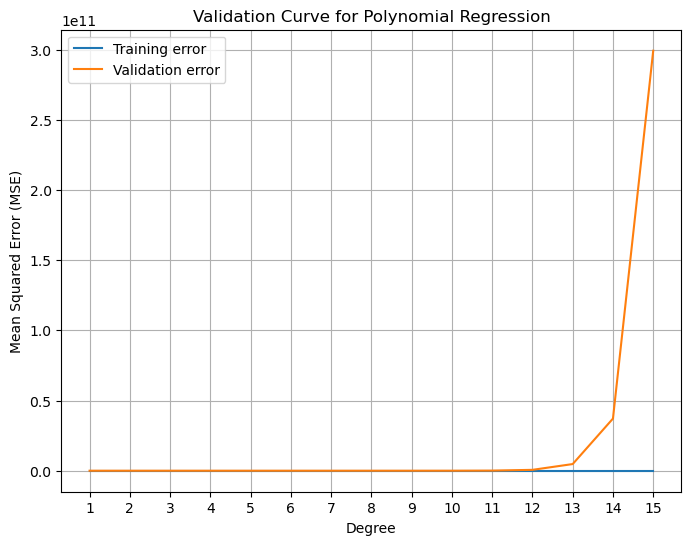

El grado óptimo del polinomio es: 1
Métricas para el grado óptimo (1):
  RMSE: 3.4050
  MAE: 2.8058
  R2: 0.5145
  RSE: 0.5675
Validación cruzada con k-folds (k=5) para grado 1:
  RMSE CV: 3.7110
  MAE  CV: 3.2117
  R2   CV: 0.2167


In [36]:
x = df[['NaOH', "H2O2", 'Dmedio']]  # Características
y = df['WI']  # Variable objetivo

# 2. Definir el modelo y el rango de grados
def PolynomialRegression(degree=2):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])

param_range = np.arange(1, 16)  # Probamos grados del 1 al 15

# 3. Calcular la curva de validación
train_scores, test_scores = validation_curve(
    PolynomialRegression(),
    x, y,
    param_name="poly__degree",
    param_range=param_range,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# 4. Visualizar los resultados
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_scores_mean, label="Training error")
plt.plot(param_range, test_scores_mean, label="Validation error")
plt.xticks(param_range)
plt.xlabel("Degree")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.title("Validation Curve for Polynomial Regression")
plt.grid(True)
plt.show()

# 5. Interpretar la curva y calcular métricas
best_degree = param_range[np.argmax(np.min(test_scores,axis=1))]
print(f"El grado óptimo del polinomio es: {best_degree}")

# Entrenar el modelo final con el grado óptimo
final_model = PolynomialRegression(degree=best_degree)
final_model.fit(x, y)
y_pred = final_model.predict(x)  # Predecir sobre los datos originales para calcular métricas

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
rse = np.sqrt(mean_squared_error(y, y_pred) / (len(y) - 2))  # RSE (Residual Standard Error)

print(f"Métricas para el grado óptimo ({best_degree}):")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R2: {r2:.4f}")
print(f"  RSE: {rse:.4f}")

# 6. VALIDACIÓN CRUZADA K-FOLDS 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_cv = PolynomialRegression(degree=best_degree)

# RMSE CV: obtenemos MSE negativo y lo convertimos a RMSE
mse_scores = -cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rmse_scores = np.sqrt(mse_scores)

# MAE CV
mae_scores = -cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
# R² CV
r2_scores = cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

print(f"Validación cruzada con k-folds (k=5) para grado {best_degree}:")
print(f"  RMSE CV: {rmse_scores.mean():.4f}")
print(f"  MAE  CV: {mae_scores.mean():.4f}")
print(f"  R2   CV: {r2_scores.mean():.4f}")

In [37]:
##Calculamos metricas para grado 3, que utilizando la media de los resultados es el mejor grado obtenido

best_degree = param_range[np.argmax(np.median(test_scores,axis=1))]
print(f"El grado óptimo del polinomio es: {best_degree}")

# Entrenar el modelo final con el grado óptimo
final_model = PolynomialRegression(degree=best_degree)
final_model.fit(x, y)
y_pred = final_model.predict(x)  # Predecir sobre los datos originales para calcular métricas

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
rse = np.sqrt(mean_squared_error(y, y_pred) / (len(y) - 2))  # RSE (Residual Standard Error)

print(f"Métricas para el grado óptimo ({best_degree}):")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE: {mae:.4f}")
print(f"  R2: {r2:.4f}")
print(f"  RSE: {rse:.4f}")

# 6. VALIDACIÓN CRUZADA K-FOLDS 
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model_cv = PolynomialRegression(degree=best_degree)

# RMSE CV: obtenemos MSE negativo y lo convertimos a RMSE
mse_scores = -cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rmse_scores = np.sqrt(mse_scores)

# MAE CV
mae_scores = -cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
# R² CV
r2_scores = cross_val_score(
    model_cv,
    x, y,
    cv=kf,
    scoring='r2',
    n_jobs=-1
)

print(f"Validación cruzada con k-folds (k=5) para grado {best_degree}:")
print(f"  RMSE CV: {rmse_scores.mean():.4f}")
print(f"  MAE  CV: {mae_scores.mean():.4f}")
print(f"  R2   CV: {r2_scores.mean():.4f}")

El grado óptimo del polinomio es: 3
Métricas para el grado óptimo (3):
  RMSE: 2.6123
  MAE: 1.8026
  R2: 0.7142
  RSE: 0.4354
Validación cruzada con k-folds (k=5) para grado 3:
  RMSE CV: 4.3335
  MAE  CV: 3.1436
  R2   CV: 0.0136


<h5>Al observar que el mejor grado para el polinomio es 1, se puede decir que entonces utilizar un grado 3, que aunque en las metricas son mejores en un principio, con un R<sup>2</sup>=0.71, al realizar la validación cruzada nos damos cuenta que el R<sup>2</sup> cae drasticamente a 0.01, en contraste a que cuando se utiliza el grado=1, con un R<sup>2</sup>=0.51, al hacer la validación cruzada obtenemos un R<sup>2</sup>=0.21, que aunque no sigue siendo un valor muy bueno, es mucho mejor comparado al valor obtenido con el grado 3, por lo que podemos concluir que utilizar un grado 3 se ajusta muy bien a la muestra pero no a los datos en general, por lo que es un <i>Sobreajuste</i>, y el mejor grado para utilizar en este caso sería el grado 1, osea un modelo lineal con interacciones

<h2>4. Regularización por Lasso al modelo polinomial

In [38]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# 2. Definir y crear el Pipeline para Lasso con Regresión Polinomial
def PolynomialLassoRegression(degree=2, alphas=np.logspace(-4, 0, 10), cv=5, max_iter=10000, tol=0.001):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('lasso_cv', LassoCV(alphas=alphas, cv=cv, max_iter=max_iter, tol=tol))
    ])

pipeline_lasso_poly = PolynomialLassoRegression(degree=3,
                                                alphas=np.logspace(-4, 0, 100),
                                                cv=5,
                                                max_iter=10000,
                                                tol=0.001)

# 3. Entrenar el modelo
pipeline_lasso_poly.fit(X_train, y_train)

# 4. Hacer predicciones y evaluar
y_pred_lasso_poly_test = pipeline_lasso_poly.predict(X_test)

rmse_lasso_poly = np.sqrt(mean_squared_error(y_test, y_pred_lasso_poly_test))
r2_lasso_poly = r2_score(y_test, y_pred_lasso_poly_test)
mae_lasso_poly = mean_absolute_error(y_test, y_pred_lasso_poly_test)

print("\n--- Modelo LassoCV con Regresión Polinomial (Grado 3, Evaluación en Test) ---")
print(f"Mejor alpha para Lasso (polinomial): {pipeline_lasso_poly.named_steps['lasso_cv'].alpha_:.4f}")
print(f'RMSE (prueba): {rmse_lasso_poly:.2f}')
print(f'R² (prueba): {r2_lasso_poly:.2f}')
print(f'MAE (prueba): {mae_lasso_poly:.2f}')

# 5.  Identificar características eliminadas
poly_features_step = pipeline_lasso_poly.named_steps['poly_features']
feature_names_poly = poly_features_step.get_feature_names_out(X_train.columns) # Usar X_train.columns
coefs_lasso_poly = pipeline_lasso_poly.named_steps['lasso_cv'].coef_

print("\nCoeficientes del modelo LassoCV con Regresión Polinomial (Grado 3):")
for feature, coef in zip(feature_names_poly, coefs_lasso_poly):
    if not np.isclose(coef, 0):
        print(f"    >> {feature}: {coef:.4f}")

features_eliminadas_poly = [name for name, coef in zip(feature_names_poly, coefs_lasso_poly) if np.isclose(coef, 0)]
print(f"Características eliminadas por Lasso (modelo polinomial): {len(features_eliminadas_poly)} de {len(feature_names_poly)}")
print(f"Nombres de características eliminadas: {features_eliminadas_poly}")


--- Modelo LassoCV con Regresión Polinomial (Grado 3, Evaluación en Test) ---
Mejor alpha para Lasso (polinomial): 0.4751
RMSE (prueba): 5.33
R² (prueba): -0.79
MAE (prueba): 3.98

Coeficientes del modelo LassoCV con Regresión Polinomial (Grado 3):
    >> NaOH H2O2: 0.8510
    >> H2O2^2: -1.1512
    >> NaOH^3: -0.0320
    >> NaOH^2 Dmedio: 0.4042
    >> NaOH Dmedio^2: -0.2357
    >> H2O2^3: 1.6127
    >> H2O2 Dmedio^2: 0.6778
    >> Dmedio^3: 0.3560
Características eliminadas por Lasso (modelo polinomial): 11 de 19
Nombres de características eliminadas: ['NaOH', 'H2O2', 'Dmedio', 'NaOH^2', 'NaOH Dmedio', 'H2O2 Dmedio', 'Dmedio^2', 'NaOH^2 H2O2', 'NaOH H2O2^2', 'NaOH H2O2 Dmedio', 'H2O2^2 Dmedio']
